This notebook is to try out different architectures of NNs

In [46]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
%run 'Functions.ipynb'

In [12]:
chunk='S7'
data, labels, unique_mutations[chunk], aa_seq = read_data_all_positions(chunk)

In [13]:
input_file = '/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Katya/NN/data/' + chunk + '.txt'
data = pd.read_table(input_file)

In [14]:
weights = {}
predicted = {}
fitness_potential = {}
true = {}
biases = {}

for chunk in chunks:    
    min_max_scaler = MinMaxScaler()
    n_iter = 500

    print (chunk)
    data, labels, unique_mutations[chunk], aa_seq = read_data_all_positions(chunk)

    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

    model = Sequential()

    model.add(Dense(1, input_dim=data.shape[1], activation='tanh', kernel_initializer='glorot_normal'))
    model.add(Dense(100, activation='tanh', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='tanh', kernel_initializer='glorot_normal'))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)

    hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                            epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

    proba = model.predict_proba(data, batch_size=500, verbose=0)

    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]

    true[chunk] = labels
    predicted[chunk] = min_max_scaler.inverse_transform(proba)
    predicted[chunk] = predicted[chunk].flatten()
    fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S1


/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2096: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


S2
S3


/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/keras/models.py:976: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


S4
S5
S6
S7
S8
S9
S10
S11
S12


In [15]:
def extract_weights(chunk):
    
    cols = set([x[-1] for x in unique_mutations[chunk]])
    ind = sorted(list(set([int(x[:-1]) for x in unique_mutations[chunk]])))
    weightsDF = pd.DataFrame(columns=cols,index=ind)

    for i,weight in enumerate(weights[chunk]):
        weightsDF.ix[int(unique_mutations[chunk][i][:-1])][unique_mutations[chunk][i][-1]] = weight[0]

    weightsDF = weightsDF.fillna(-10)

    return weightsDF

In [16]:
def mut_num_to_absolute(unique_mutations,chunk,position_translation):
    
    for i,mut in enumerate(unique_mutations[chunk]):
        unique_mutations[chunk][i] = str(int(position_translation.ix[int(mut[:-1])][chunk])) + mut[-1] 

In [17]:
position_translation=pd.DataFrame.from_csv('/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/position_translation.csv',sep='\t')

for chunk in chunks:
    mut_num_to_absolute(unique_mutations,chunk,position_translation)

In [19]:
for chunk in chunks:

    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    if R>0:
        fitness_potential[chunk]*=-1
        weights[chunk]*=-1
        
    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    print chunk, '\t', R

S1 	-0.77644141741
S2 	-0.807635283731
S3 	-0.805923096368
S4 	-0.837149152139
S5 	-0.544800840878
S6 	-0.814476031669
S7 	-0.826527849286
S8 	-0.829113194696
S9 	-0.899961916011
S10 	-0.0999881752218
S11 	-0.889696866111
S12 	-0.659153963746


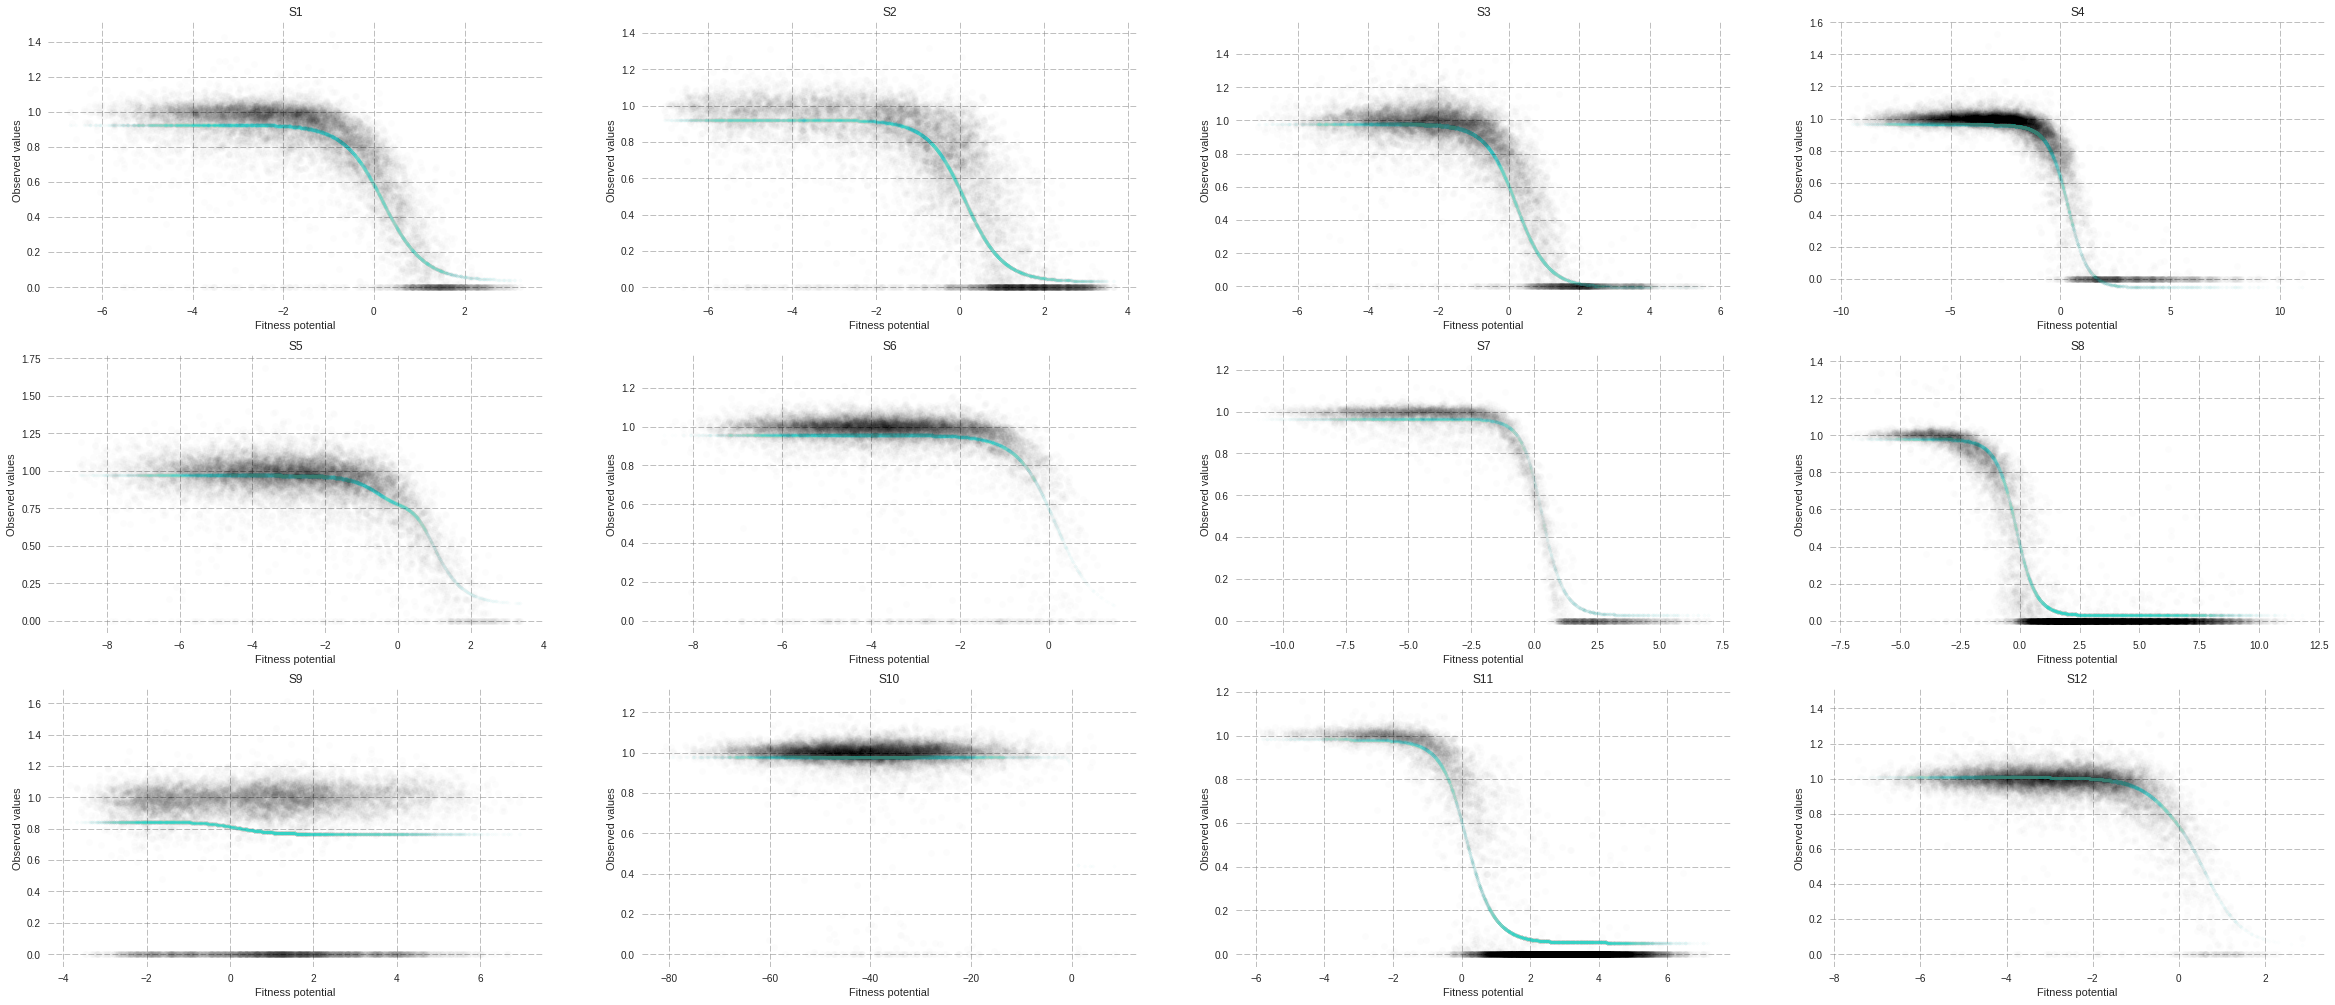

In [20]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Observed values')
    count+=1

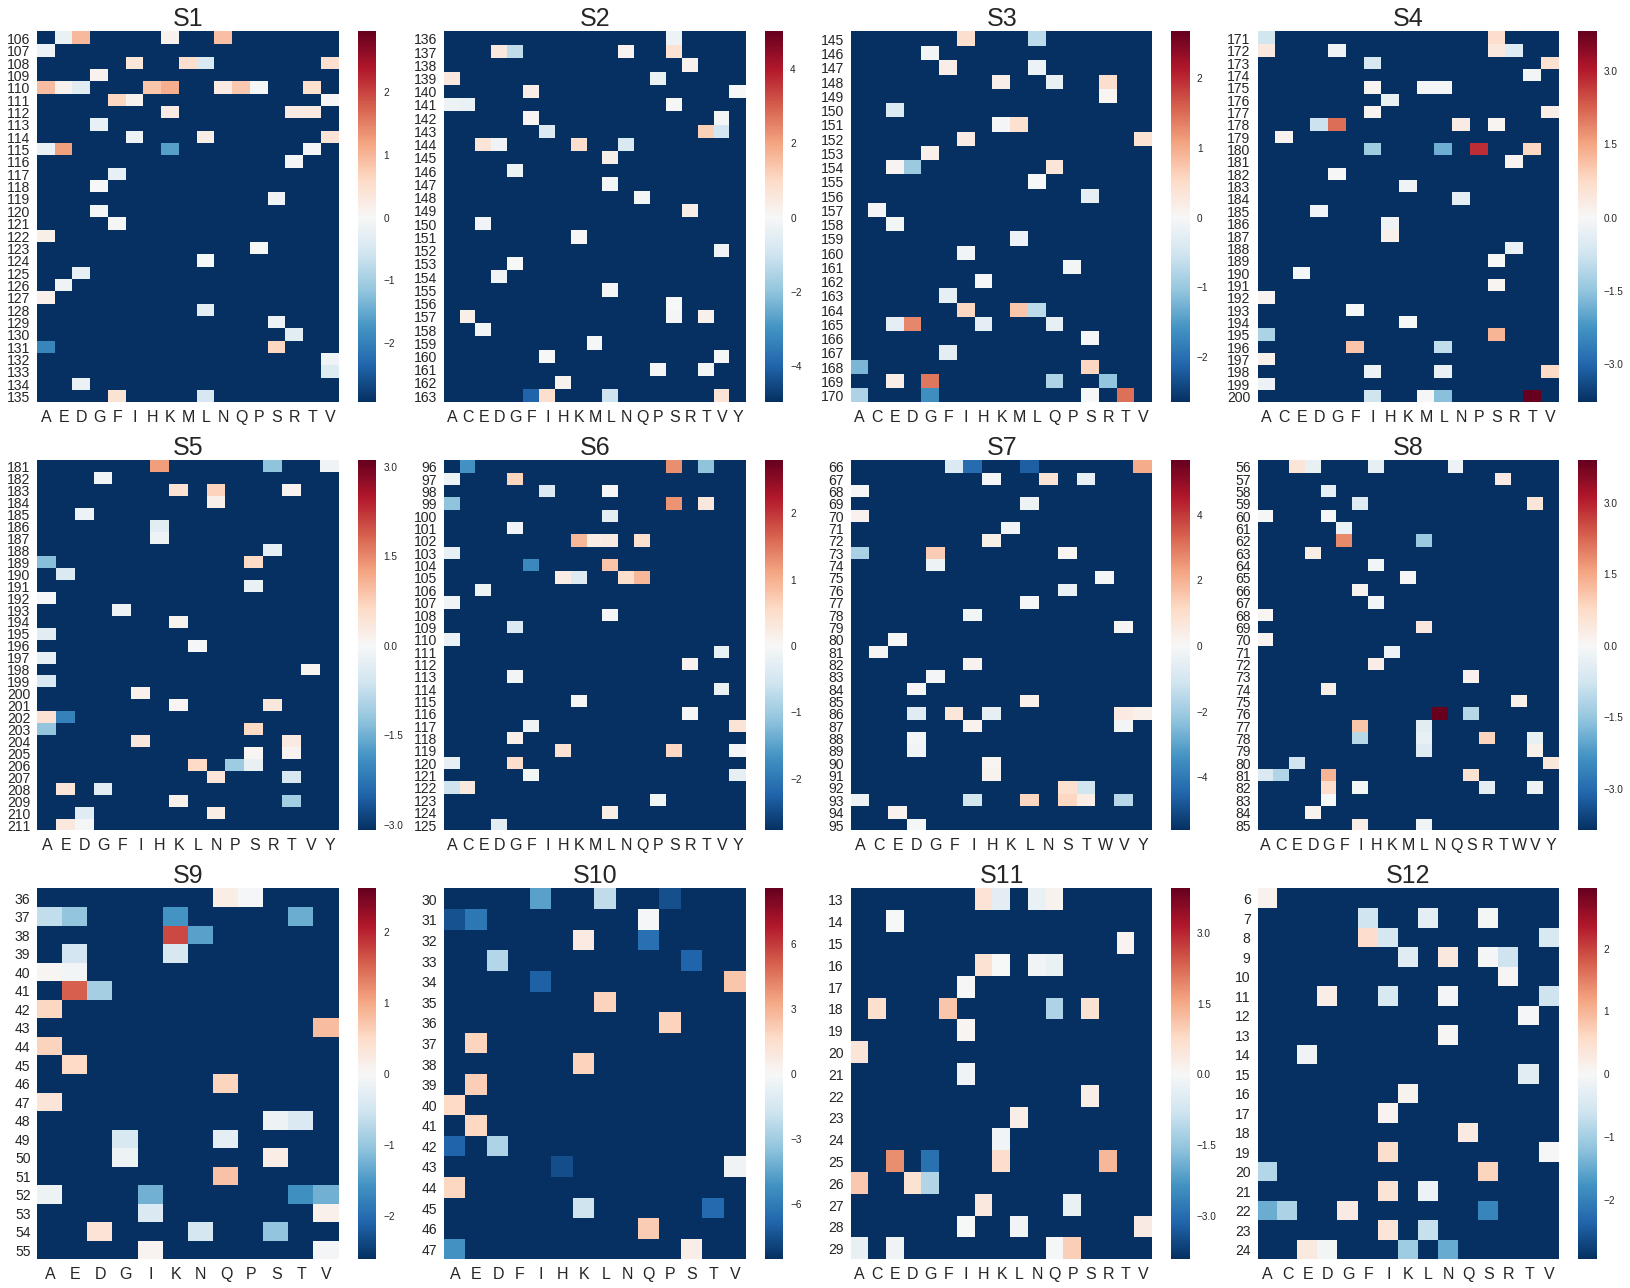

In [39]:
plt.figure(figsize=(4*5+3,3*6))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.tight_layout()
    plt.title(chunk,fontsize=25)
    tempDF = extract_weights(chunk)
    sns.heatmap(tempDF, vmin=min(tempDF[tempDF>-10].min()-1), vmax=max(tempDF.max()))
    plt.xticks(rotation=0,fontsize=16) 
    plt.yticks(rotation=0,fontsize=14) 
    count+=1
plt.savefig('/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Katya/weights_split_chunks.pdf')

In [166]:
all_unique_mutations = []
all_weights = []
for chunk in chunks:
    all_unique_mutations.extend(unique_mutations[chunk])
    all_weights.extend(weights[chunk])

In [167]:
cols = set([x[-1] for x in all_unique_mutations])
ind = sorted(list(set([int(x[:-1]) for x in all_unique_mutations])))
weightsDF = pd.DataFrame(columns=cols,index=ind)

for i,weight in enumerate(all_weights):
    weightsDF.ix[int(all_unique_mutations[i][:-1])][all_unique_mutations[i][-1]] = weight[0]

weightsDF = weightsDF.fillna(-10)

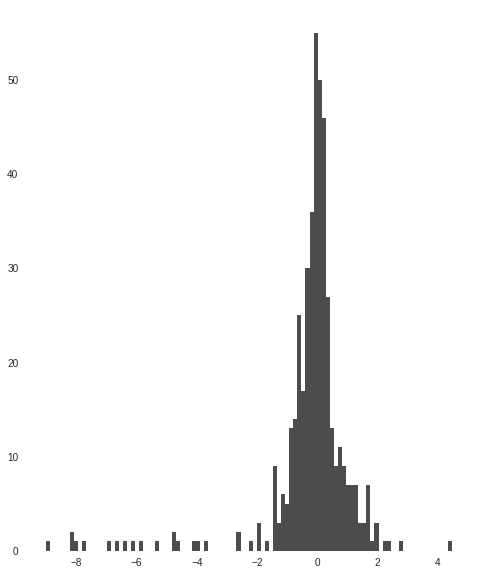

In [187]:
test=weightsDF.values
plt.figure(figsize=[8,10])
plt.hist(test[test>-10],bins=100,color='k',alpha=0.7);

In [189]:
samples = 0

for chunk in chunks:    
    print (chunk)
    data, labels, unique_mutations[chunk], aa_seq = read_data_all_positions(chunk)
    
    samples+=len(data)
    
    print samples

S1
58066
S2
103723
S3
151921
S4
196176
S5
247298
S6
292578
S7
296891
S8
343198
S9
373190
S10
403027
S11
419790
S12
452709


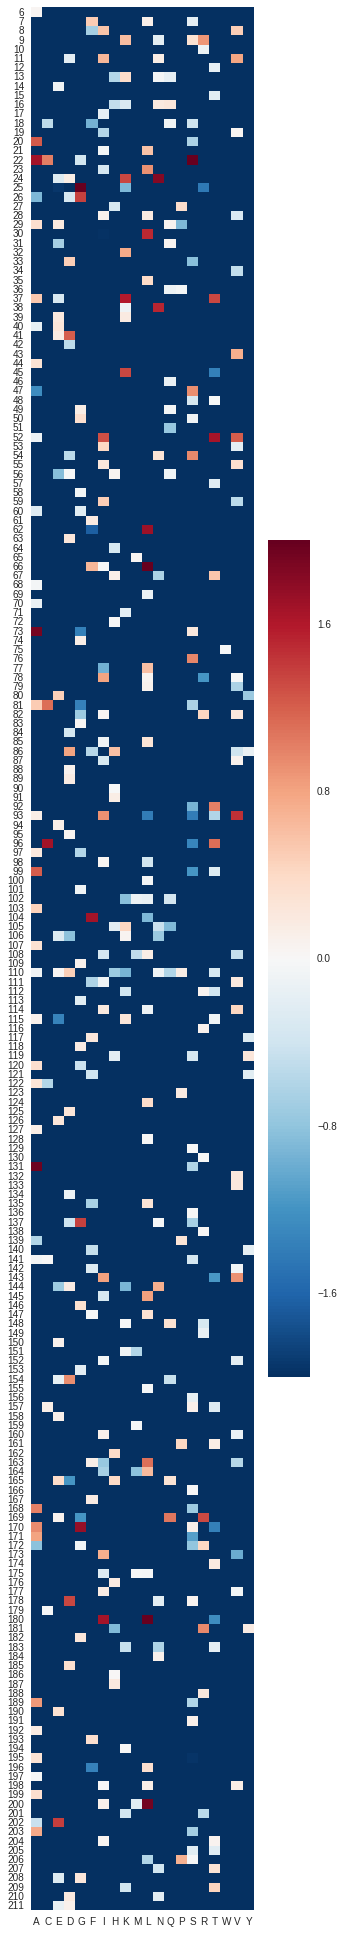

In [188]:
plt.figure(figsize=[5,35])
sns.heatmap(weightsDF, vmin=-2, vmax=2)
plt.savefig('/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Katya/weights.pdf')